In [2]:
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR

from sklearn.model_selection import cross_val_score

from google.colab import files

#前処理

In [3]:
train = pd.read_csv('train.csv', encoding='utf-8', engine='python')
test = pd.read_csv('test.csv', encoding='utf-8', engine='python')

In [4]:
label = ['y', 'accommodates', 'bedrooms', 'beds', 'room_type', 'city', 'host_response_rate', 'review_scores_rating']
label_test = ['accommodates', 'bedrooms', 'beds', 'room_type', 'city', 'host_response_rate', 'review_scores_rating']

train1 = pd.DataFrame()
for i in label:
  train1[i] = train[i]

test1 = pd.DataFrame()
for i in label_test:
  test1[i] = test[i]

train2 = pd.concat([train1, test1], axis=0)

In [5]:
#ダミー変数
room_type = set(train['room_type'])
city = set(train['city'])

for i in room_type:
  train2[i] = 0
for i in city:
  train2[i] = 0

for i in range(len(train2)):
  for j in room_type:
    if train2.iat[i, train2.columns.get_loc('room_type')] == j:
      train2.iat[i, train2.columns.get_loc(j)] = 1
  for j in city:
    if train2.iat[i, train2.columns.get_loc('city')] == j:
      train2.iat[i, train2.columns.get_loc(j)] = 1

train2 = train2.drop(['room_type', 'city'], axis=1)

In [6]:
#%を取り除く
for i in range(len(train2)):
  train2.iat[i, train2.columns.get_loc('host_response_rate')] = float(str(train2.iat[i, train2.columns.get_loc('host_response_rate')]).replace('%', ''))

##欠損値

In [7]:
train2.isna().sum()

y                       18528
accommodates                0
bedrooms                   91
beds                      131
host_response_rate      18299
review_scores_rating    16722
Shared room                 0
Entire home/apt             0
Private room                0
SF                          0
Boston                      0
DC                          0
LA                          0
NYC                         0
Chicago                     0
dtype: int64

In [8]:
for i in ['bedrooms', 'beds', 'host_response_rate', 'review_scores_rating']:
  train2[i] = train2[i].fillna(train2[i].mean())

train2.isna().sum()

y                       18528
accommodates                0
bedrooms                    0
beds                        0
host_response_rate          0
review_scores_rating        0
Shared room                 0
Entire home/apt             0
Private room                0
SF                          0
Boston                      0
DC                          0
LA                          0
NYC                         0
Chicago                     0
dtype: int64

#基礎分析

In [9]:
train3 = train2[train2.y.notna()]
test3 = train2[~train2.y.notna()]

In [10]:
train3.describe()

,y,accommodates,bedrooms,beds,host_response_rate,review_scores_rating,Shared room,Entire home/apt,Private room,SF,Boston,DC,LA,NYC,Chicago
count,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000
mean,160.163647,3.152906,1.265313,1.711769,94.364003,94.075542,0.029164,0.556627,0.414209,0.085782,0.046687,0.076624,0.302754,0.437652,0.050501
std,168.087140,2.153001,0.848777,1.256736,14.178888,6.864565,0.168266,0.496787,0.492589,0.280044,0.210969,0.265997,0.459454,0.496102,0.218978
min,1.000000,1.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,2.000000,1.000000,1.000000,94.351967,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,2.000000,1.000000,1.000000,100.000000,94.067365,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,185.000000,4.000000,1.000000,2.000000,100.000000,99.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1999.000000,16.000000,10.000000,18.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
test3.describe()

,y,accommodates,bedrooms,beds,host_response_rate,review_scores_rating,Shared room,Entire home/apt,Private room,SF,Boston,DC,LA,NYC,Chicago
count,0.0,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000,18528.000000
mean,NaN,3.161863,1.267234,1.708165,94.315862,94.042835,0.029253,0.559747,0.411000,0.089918,0.047118,0.077127,0.303595,0.433020,0.049223
std,NaN,2.155397,0.860116,1.241888,14.189611,6.989594,0.168519,0.496431,0.492028,0.286072,0.211897,0.266799,0.459822,0.495507,0.216339
min,NaN,1.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,2.000000,1.000000,1.000000,94.351967,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,2.000000,1.000000,1.000000,100.000000,94.067365,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,4.000000,1.000000,2.000000,100.000000,99.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,NaN,16.000000,10.000000,16.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


IndexError: ignored

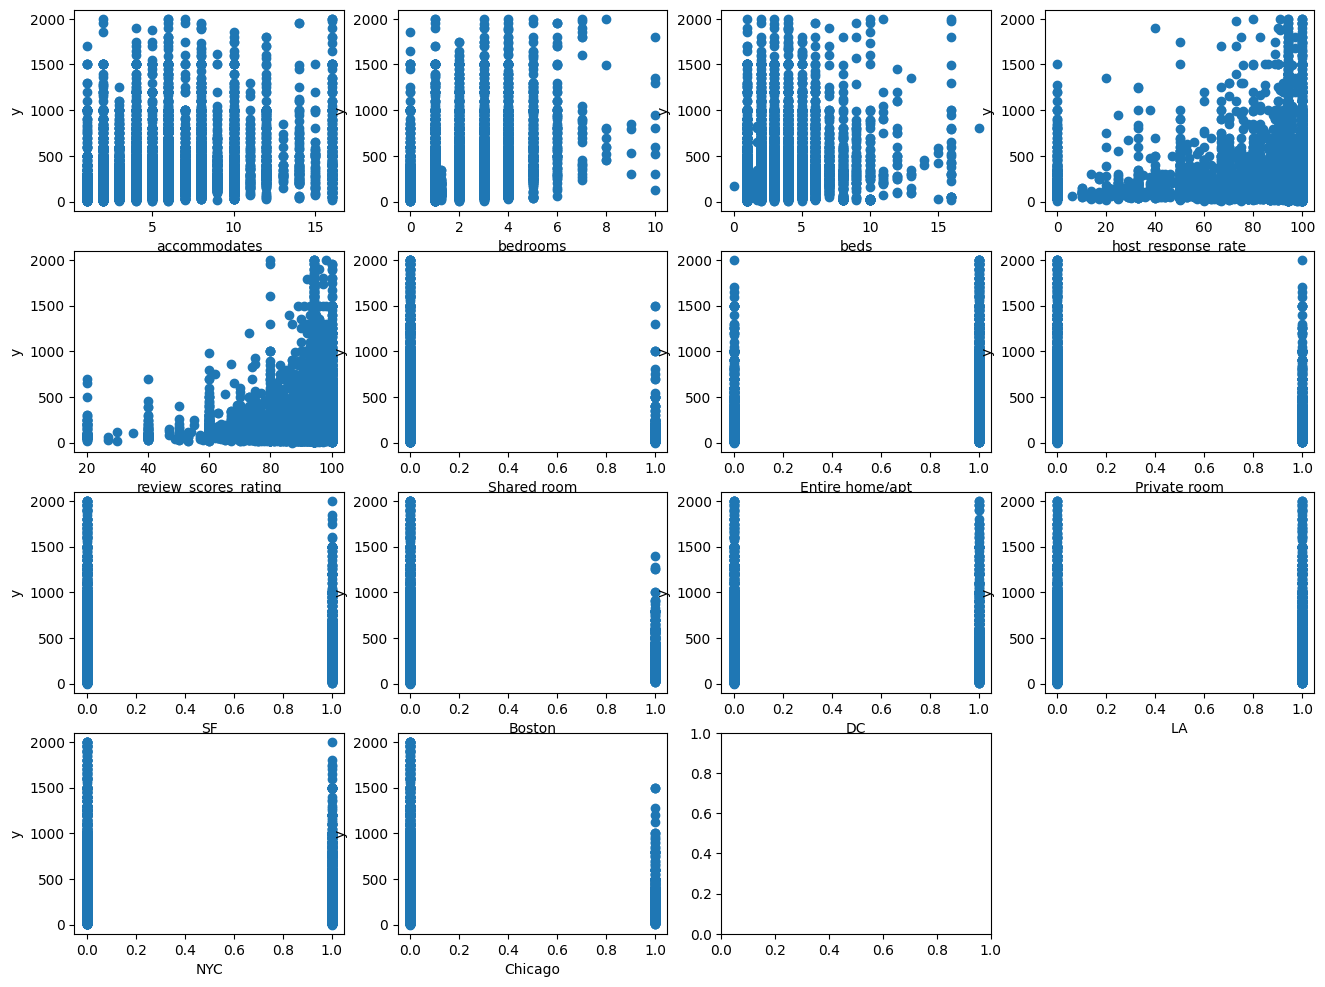

In [12]:
#散布図
label2 = train3.columns.values

fig = plt.figure(figsize=(16, 12))

for i in range(len(label2)):
  ax = fig.add_subplot(4, 4, i+1)
  ax.scatter(train3[label2[i+1]], train3['y'])
  ax.set_xlabel(label2[i+1])
  ax.set_ylabel('y')

#検証

In [13]:
df_train, df_test = train_test_split(train3, test_size=0.3)

In [14]:
予測変数1 = ['accommodates', 'bedrooms', 'beds', 'host_response_rate', 'review_scores_rating']
予測変数2 = ['accommodates', 'bedrooms', 'beds', 'host_response_rate', 'review_scores_rating', 'Shared room', 'NYC', 'Chicago', 'SF', 'LA', 'Boston', 'DC']
予測変数3 = ['accommodates', 'bedrooms', 'beds', 'host_response_rate', 'review_scores_rating', 'Private room', 'Entire home/apt', 'Shared room']
予測変数L = ['accommodates', 'bedrooms', 'beds', 'host_response_rate', 'review_scores_rating', 'Private room', 'Entire home/apt', 'Shared room', 'NYC', 'Chicago', 'SF', 'LA', 'Boston', 'DC']

In [25]:
model = [LinearRegression(), Ridge(alpha=1), LinearSVR()]

In [ ]:
rmsescore_LinearRegression = dict()
rmsescore_Ridge = dict()
rmsescore_LinearSVR = dict()

for i, 予測変数 in enumerate([予測変数1, 予測変数2, 予測変数3, 予測変数L]):
  cv_rmse = - cross_val_score(LinearRegression(), df_train[予測変数], df_train.y, cv=5, scoring='neg_root_mean_squared_error')
  rmsescore_LinearRegression[i] = np.mean(cv_rmse)

for i, 予測変数 in enumerate([予測変数1, 予測変数2, 予測変数3, 予測変数L]):
  cv_rmse = - cross_val_score(Ridge(alpha=1), df_train[予測変数], df_train.y, cv=5, scoring='neg_root_mean_squared_error')
  rmsescore_Ridge[i] = np.mean(cv_rmse)

for i, 予測変数 in enumerate([予測変数1, 予測変数2, 予測変数3, 予測変数L]):
  cv_rmse = - cross_val_score(LinearSVR(), df_train[予測変数], df_train.y, cv=5, scoring='neg_root_mean_squared_error')
  rmsescore_LinearSVR[i] = np.mean(cv_rmse)

In [51]:
pd.Series(rmsescore_LinearRegression)

0    140.022980
1    137.209337
2    136.596092
3    134.219642
dtype: float64

In [52]:
pd.Series(rmsescore_Ridge)

0    140.022973
1    137.209324
2    136.596082
3    134.219627
dtype: float64

In [53]:
pd.Series(rmsescore_LinearSVR)

0    148.295920
1    145.337720
2    143.308261
3    141.871623
dtype: float64

#投稿

In [54]:
model = Ridge(alpha=1)
model.fit(df_train[予測変数L], df_train.y)
model.predict(test3[予測変数L])

array([281.00024548, 165.2041724 ,  29.19919198, ..., 213.05619099,
       146.72870183,  38.45884495])

In [55]:
df_sample = pd.read_csv('sample_submit.csv', header=None)
df_sample[1] = model.predict(test3[予測変数L])
df_sample

,0,1
0,0,281.000245
1,1,165.204172
2,2,29.199192
3,3,191.223560
4,4,149.965422
...,...,...
18523,18523,245.006562
18524,18524,151.873353
18525,18525,213.056191
18526,18526,146.728702


In [56]:
df_sample.to_csv('sample_submit2.csv', index=False, header=False)
files.download("sample_submit2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#出力

In [49]:
train3.describe().to_csv("BigData1_基本統計量.csv")
files.download("BigData1_基本統計量.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>